# 🐶🐱 Dog vs Cat Classification using Support Vector Machine (SVM)

## 📊 Project Overview

This notebook demonstrates **Support Vector Machine (SVM)** for **binary image classification** - predicting whether an image contains a Dog or a Cat.

### 🎯 Learning Objectives:
- Understand SVM for image classification
- Learn two feature extraction techniques:
  - **HOG (Histogram of Oriented Gradients)**
  - **Raw Pixels with PCA (Principal Component Analysis)**
- Compare different SVM kernels (Linear, RBF, Polynomial)
- Evaluate using comprehensive classification metrics
- Compare feature extraction methods

---

## 🔍 Why SVM for Image Classification?

### Advantages of SVM:

| Aspect | Description |
|--------|-------------|
| **Robust** | Works well even with limited data |
| **Effective** | Excellent for binary classification |
| **Kernel Trick** | Handles non-linear relationships |
| **Memory Efficient** | Only uses support vectors |
| **High Accuracy** | Often achieves competitive results |

### Image Classification Pipeline:

```
1. Load Images
      ↓
2. Preprocess (Resize, Grayscale, Normalize)
      ↓
3. Feature Extraction (HOG or PCA)
      ↓
4. Train SVM Model
      ↓
5. Evaluate & Compare
```

---

## 📚 Import Libraries

In [3]:
# Data manipulation
import numpy as np
import pandas as pd
import os
from glob import glob
import time

# Image processing
from PIL import Image
import cv2
from skimage.feature import hog
from skimage import exposure

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Machine Learning - Models
from sklearn.svm import SVC

# Machine Learning - Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, matthews_corrcoef,
    cohen_kappa_score, log_loss, balanced_accuracy_score
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 📁 Load Dataset

**Dataset**: Microsoft Cats vs Dogs Dataset

### Dataset Information:
- **Source**: Microsoft Research
- **Total Images**: ~25,000 images
- **Classes**: 2 (Cat = 0, Dog = 1)
- **Cat Images**: ~12,500
- **Dog Images**: ~12,500
- **Format**: JPG images of various sizes

### Loading Strategy:
We'll load all images, but you can modify `max_images_per_class` to limit the dataset size for faster experimentation.

In [4]:
# Define paths
dataset_path = '../../dataset/PetImages'
cat_path = os.path.join(dataset_path, 'Cat')
dog_path = os.path.join(dataset_path, 'Dog')

# Check if paths exist
print("📂 Checking dataset paths...")
print(f"Cat path exists: {os.path.exists(cat_path)}")
print(f"Dog path exists: {os.path.exists(dog_path)}")

# Count images
cat_images = glob(os.path.join(cat_path, '*.jpg'))
dog_images = glob(os.path.join(dog_path, '*.jpg'))

print(f"\n📊 Dataset Statistics:")
print("="*50)
print(f"Total Cat images: {len(cat_images)}")
print(f"Total Dog images: {len(dog_images)}")
print(f"Total images: {len(cat_images) + len(dog_images)}")
print(f"Dataset is balanced: {abs(len(cat_images) - len(dog_images)) < 100}")

📂 Checking dataset paths...
Cat path exists: True
Dog path exists: True

📊 Dataset Statistics:
Total Cat images: 12499
Total Dog images: 12499
Total images: 24998
Dataset is balanced: True


### Visualize Sample Images

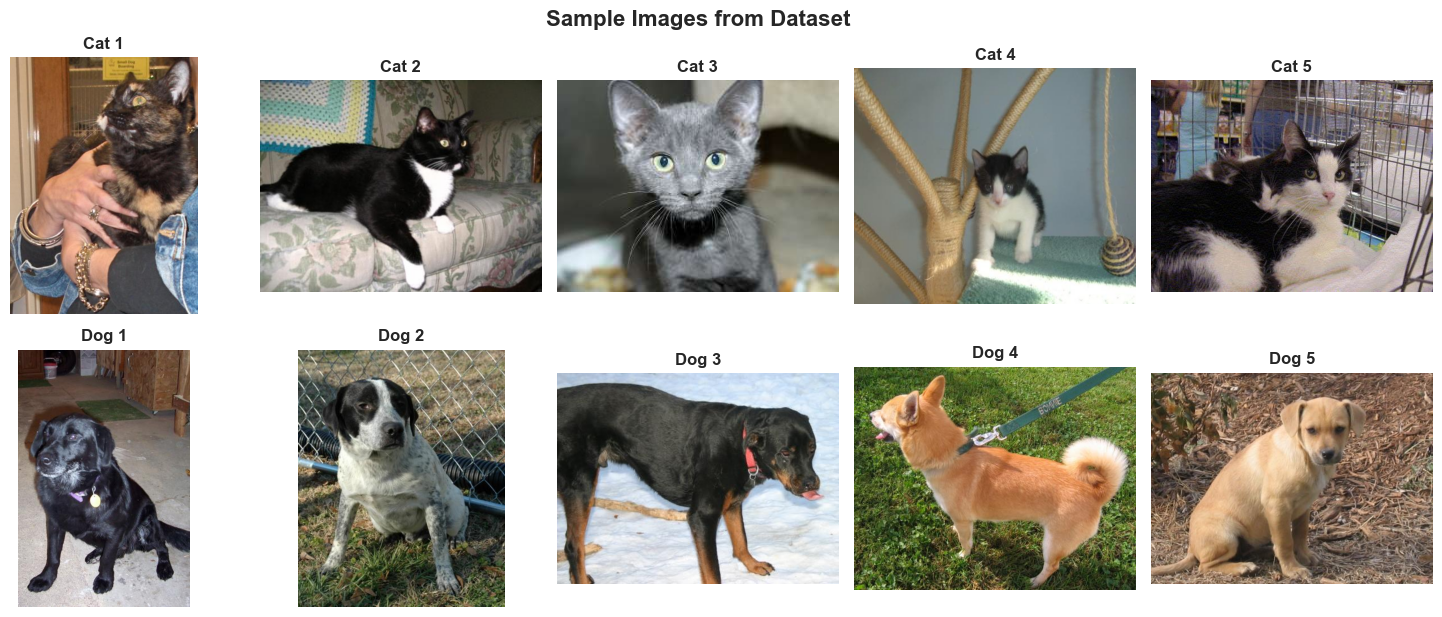

In [5]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Show 5 cat images
for i in range(5):
    img = Image.open(cat_images[i])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Cat {i+1}', fontweight='bold')
    axes[0, i].axis('off')

# Show 5 dog images
for i in range(5):
    img = Image.open(dog_images[i])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Dog {i+1}', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 🔧 Data Preprocessing

### Step 1: Load and Preprocess Images

**Preprocessing Steps:**
1. **Load image**: Read from disk
2. **Resize**: Standardize to 128x128 pixels
3. **Convert to grayscale**: Reduce from 3 channels to 1
4. **Normalize**: Scale pixel values to [0, 1]
5. **Error handling**: Skip corrupted images

**Note**: This may take several minutes depending on dataset size.

In [6]:
# Configuration
IMG_SIZE = 128  # Resize all images to 128x128
MAX_IMAGES_PER_CLASS = None  # Set to None for all images, or a number to limit (e.g., 5000)

def load_and_preprocess_image(image_path, img_size=128):
    """
    Load and preprocess a single image.
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
    img_size : int
        Target size for resizing (img_size x img_size)
    
    Returns:
    --------
    numpy.ndarray or None
        Preprocessed image as grayscale array, or None if error
    """
    try:
        # Read image using OpenCV
        img = cv2.imread(image_path)
        
        # Check if image was loaded successfully
        if img is None:
            return None
        
        # Resize to standard size
        img = cv2.resize(img, (img_size, img_size))
        
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Normalize to [0, 1]
        img_normalized = img_gray / 255.0
        
        return img_normalized
    
    except Exception as e:
        # Skip corrupted images
        return None

def load_dataset(cat_images, dog_images, max_images_per_class=None, img_size=128):
    """
    Load entire dataset with preprocessing.
    
    Parameters:
    -----------
    cat_images : list
        List of paths to cat images
    dog_images : list
        List of paths to dog images
    max_images_per_class : int or None
        Maximum number of images to load per class
    img_size : int
        Target size for resizing
    
    Returns:
    --------
    tuple
        (X, y) where X is array of images and y is array of labels
    """
    images = []
    labels = []
    
    # Limit dataset size if specified
    if max_images_per_class:
        cat_images = cat_images[:max_images_per_class]
        dog_images = dog_images[:max_images_per_class]
    
    print(f"\n🔄 Loading {len(cat_images)} Cat images...")
    start_time = time.time()
    
    # Load cat images (label = 0)
    for i, img_path in enumerate(cat_images):
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{len(cat_images)} cat images...")
        
        img = load_and_preprocess_image(img_path, img_size)
        if img is not None:
            images.append(img)
            labels.append(0)  # Cat = 0
    
    cat_time = time.time() - start_time
    print(f"✅ Loaded {len([l for l in labels if l == 0])} cat images in {cat_time:.2f} seconds")
    
    print(f"\n🔄 Loading {len(dog_images)} Dog images...")
    start_time = time.time()
    
    # Load dog images (label = 1)
    for i, img_path in enumerate(dog_images):
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{len(dog_images)} dog images...")
        
        img = load_and_preprocess_image(img_path, img_size)
        if img is not None:
            images.append(img)
            labels.append(1)  # Dog = 1
    
    dog_time = time.time() - start_time
    print(f"✅ Loaded {len([l for l in labels if l == 1])} dog images in {dog_time:.2f} seconds")
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    return X, y

# Load dataset
print("🚀 Starting dataset loading...")
print("="*50)
total_start = time.time()

X_images, y = load_dataset(cat_images, dog_images, MAX_IMAGES_PER_CLASS, IMG_SIZE)

total_time = time.time() - total_start

print(f"\n" + "="*50)
print(f"✅ Dataset loading completed!")
print(f"Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"\n📊 Final Dataset Shape:")
print(f"X_images shape: {X_images.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
print(f"  Cat (0): {counts[0]} images")
print(f"  Dog (1): {counts[1]} images")

🚀 Starting dataset loading...

🔄 Loading 12499 Cat images...
  Processed 1000/12499 cat images...
  Processed 2000/12499 cat images...


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


  Processed 3000/12499 cat images...
  Processed 4000/12499 cat images...
  Processed 5000/12499 cat images...
  Processed 6000/12499 cat images...
  Processed 7000/12499 cat images...
  Processed 8000/12499 cat images...


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  Processed 9000/12499 cat images...


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  Processed 10000/12499 cat images...


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


  Processed 11000/12499 cat images...


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


  Processed 12000/12499 cat images...
✅ Loaded 12498 cat images in 28.86 seconds

🔄 Loading 12499 Dog images...
  Processed 1000/12499 dog images...


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


  Processed 2000/12499 dog images...
  Processed 3000/12499 dog images...
  Processed 4000/12499 dog images...


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


  Processed 5000/12499 dog images...
  Processed 6000/12499 dog images...


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


  Processed 7000/12499 dog images...


  Processed 8000/12499 dog images...
  Processed 9000/12499 dog images...


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


  Processed 10000/12499 dog images...


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


  Processed 11000/12499 dog images...


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


  Processed 12000/12499 dog images...


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


✅ Loaded 12499 dog images in 28.30 seconds

✅ Dataset loading completed!
Total time: 59.37 seconds (0.99 minutes)

📊 Final Dataset Shape:
X_images shape: (24997, 128, 128)
y shape: (24997,)

Class distribution:
  Cat (0): 12498 images
  Dog (1): 12499 images


### Visualize Preprocessed Images

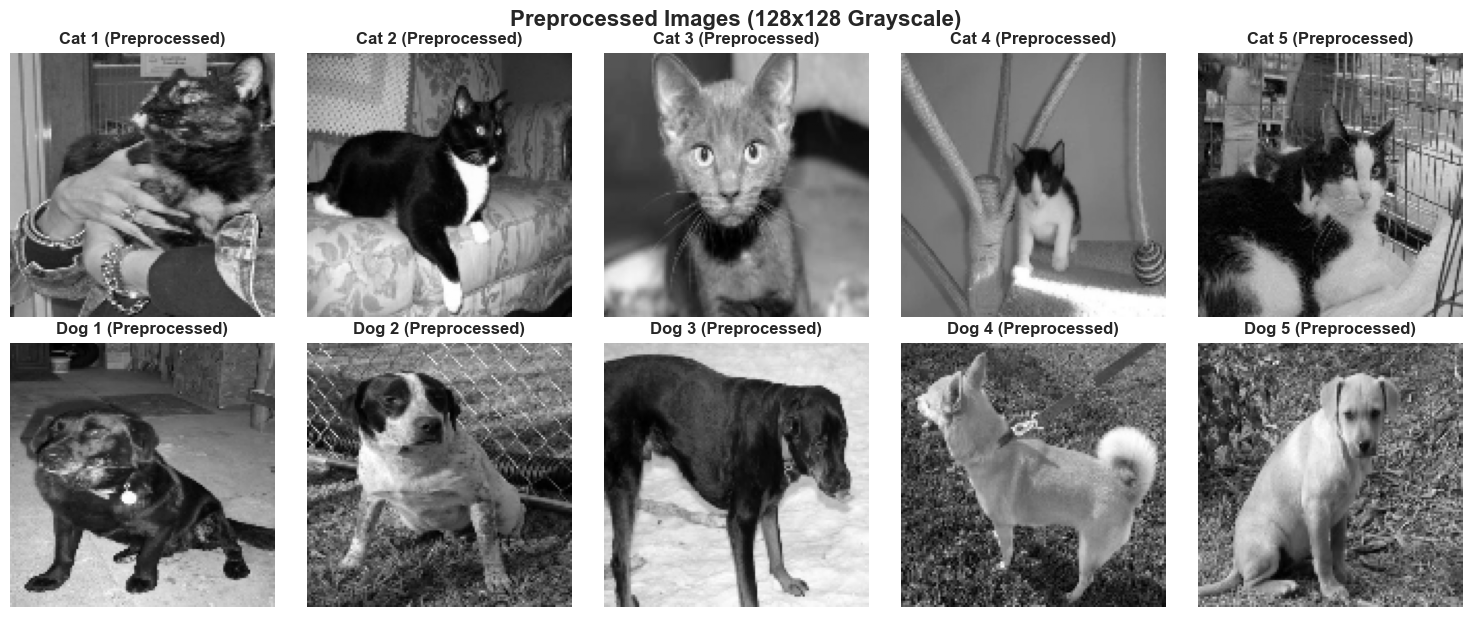

In [7]:
# Display preprocessed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Find indices for cats and dogs
cat_indices = np.where(y == 0)[0][:5]
dog_indices = np.where(y == 1)[0][:5]

# Show preprocessed cat images
for i, idx in enumerate(cat_indices):
    axes[0, i].imshow(X_images[idx], cmap='gray')
    axes[0, i].set_title(f'Cat {i+1} (Preprocessed)', fontweight='bold')
    axes[0, i].axis('off')

# Show preprocessed dog images
for i, idx in enumerate(dog_indices):
    axes[1, i].imshow(X_images[idx], cmap='gray')
    axes[1, i].set_title(f'Dog {i+1} (Preprocessed)', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle(f'Preprocessed Images ({IMG_SIZE}x{IMG_SIZE} Grayscale)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

### Step 2: Train-Test Split

In [8]:
# Split data into training and testing sets (80-20 split)
X_train_imgs, X_test_imgs, y_train, y_test = train_test_split(
    X_images, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data split completed!")
print("="*50)
print(f"Training set: {X_train_imgs.shape[0]} images")
print(f"Testing set: {X_test_imgs.shape[0]} images")
print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
print(f"  Cat (0): {counts[0]} images ({counts[0]/len(y_train)*100:.1f}%)")
print(f"  Dog (1): {counts[1]} images ({counts[1]/len(y_train)*100:.1f}%)")
print(f"\nTesting class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
print(f"  Cat (0): {counts[0]} images ({counts[0]/len(y_test)*100:.1f}%)")
print(f"  Dog (1): {counts[1]} images ({counts[1]/len(y_test)*100:.1f}%)")

✅ Data split completed!
Training set: 19997 images
Testing set: 5000 images

Training class distribution:
  Cat (0): 9998 images (50.0%)
  Dog (1): 9999 images (50.0%)

Testing class distribution:
  Cat (0): 2500 images (50.0%)
  Dog (1): 2500 images (50.0%)


## 🎨 Feature Extraction Method 1: HOG (Histogram of Oriented Gradients)

### 🔍 What is HOG?

**HOG** is a feature descriptor used for object detection and recognition. It captures the **edge direction** and **magnitude** information from images.

### How HOG Works:

1. **Compute Gradients**: Calculate horizontal and vertical gradients (edges)
2. **Create Cells**: Divide image into small cells (e.g., 8x8 pixels)
3. **Compute Histogram**: For each cell, create histogram of gradient directions
4. **Normalize Blocks**: Group cells into blocks and normalize to reduce lighting effects
5. **Concatenate**: Combine all histograms into a single feature vector

### Visual Representation:

```
Original Image → Gradients → Cells → Histograms → Feature Vector
   (128x128)      (edges)    (8x8)   (9 bins)      (e.g., 8100 features)
```

### Why HOG for Images?

✅ **Robust to lighting changes**: Gradient normalization handles different lighting

✅ **Captures shape information**: Edge directions describe object shapes

✅ **Translation invariant**: Small position changes don't affect features much

✅ **Dimensionality reduction**: Converts 16,384 pixels → ~8,000 features

✅ **Proven for object detection**: Used in pedestrian detection, face recognition

### HOG Parameters:

- **orientations**: Number of gradient direction bins (default: 9)
- **pixels_per_cell**: Size of each cell (default: 8x8)
- **cells_per_block**: Cells per normalization block (default: 2x2)
- **visualize**: Generate HOG visualization image

---

### Extract HOG Features

In [9]:
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extract HOG features from a batch of images.
    
    Parameters:
    -----------
    images : numpy.ndarray
        Array of grayscale images
    orientations : int
        Number of orientation bins
    pixels_per_cell : tuple
        Size of cell (height, width) in pixels
    cells_per_block : tuple
        Number of cells in each block (rows, cols)
    
    Returns:
    --------
    numpy.ndarray
        Array of HOG feature vectors
    """
    features = []
    
    print(f"🔄 Extracting HOG features from {len(images)} images...")
    start_time = time.time()
    
    for i, img in enumerate(images):
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{len(images)} images...")
        
        # Extract HOG features
        hog_features = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=False,
            feature_vector=True
        )
        
        features.append(hog_features)
    
    features = np.array(features)
    elapsed_time = time.time() - start_time
    
    print(f"✅ HOG feature extraction completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Feature shape: {features.shape}")
    print(f"Features per image: {features.shape[1]}")
    
    return features

# Extract HOG features for training and testing sets
print("\n📊 HOG FEATURE EXTRACTION")
print("="*50)

X_train_hog = extract_hog_features(X_train_imgs)
print()
X_test_hog = extract_hog_features(X_test_imgs)


📊 HOG FEATURE EXTRACTION
🔄 Extracting HOG features from 19997 images...
  Processed 1000/19997 images...
  Processed 2000/19997 images...
  Processed 3000/19997 images...
  Processed 4000/19997 images...
  Processed 5000/19997 images...
  Processed 6000/19997 images...
  Processed 7000/19997 images...
  Processed 8000/19997 images...
  Processed 9000/19997 images...
  Processed 10000/19997 images...
  Processed 11000/19997 images...
  Processed 12000/19997 images...
  Processed 13000/19997 images...
  Processed 14000/19997 images...
  Processed 15000/19997 images...
  Processed 16000/19997 images...
  Processed 17000/19997 images...
  Processed 18000/19997 images...
  Processed 19000/19997 images...
✅ HOG feature extraction completed in 54.38 seconds (0.91 minutes)
Feature shape: (19997, 8100)
Features per image: 8100

🔄 Extracting HOG features from 5000 images...
  Processed 1000/5000 images...
  Processed 2000/5000 images...
  Processed 3000/5000 images...
  Processed 4000/5000 imag

### Visualize HOG Features

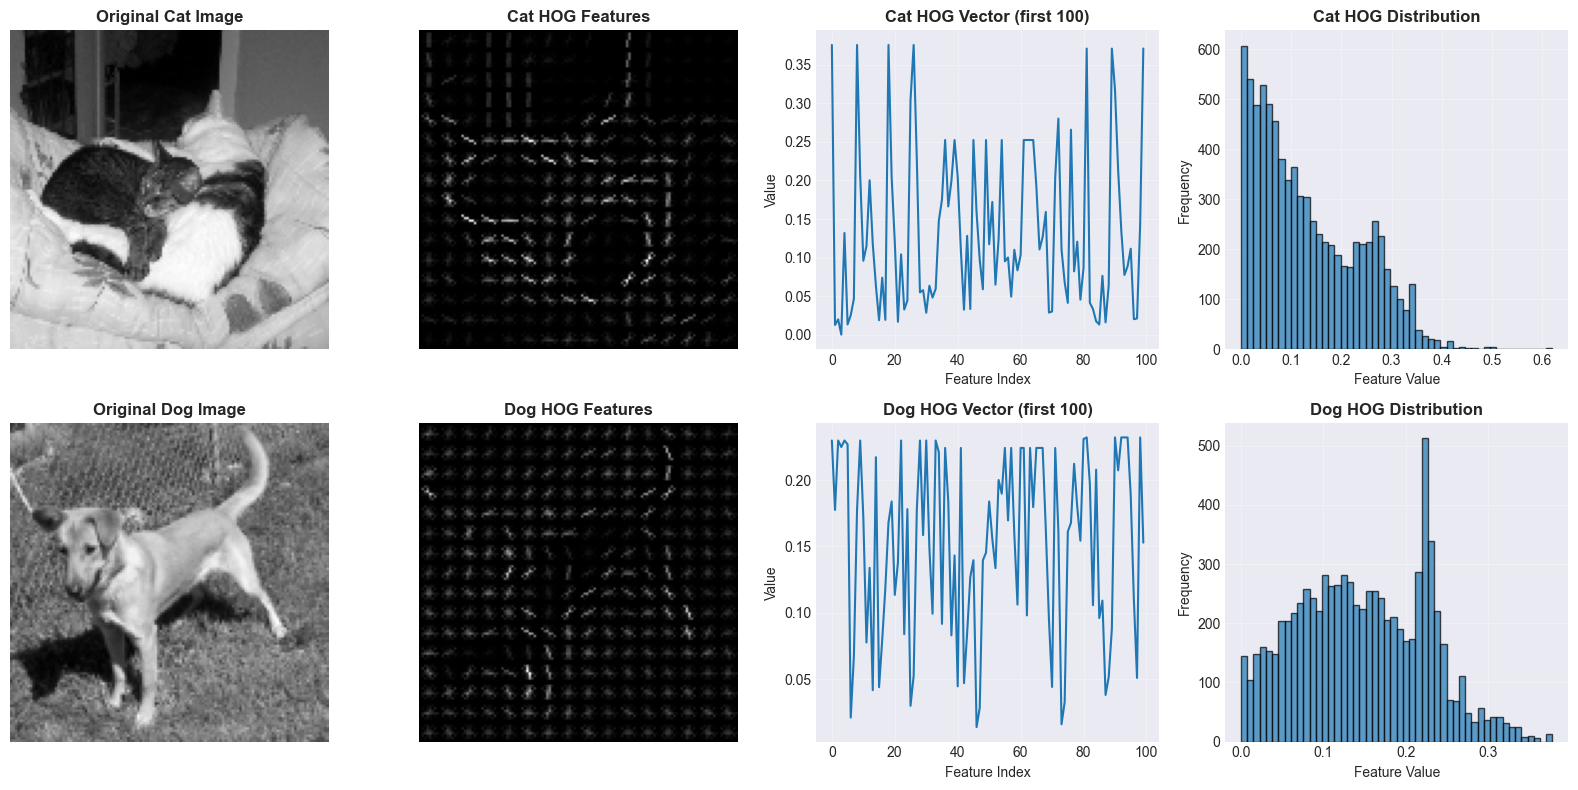


💡 HOG Visualization Explanation:
  Column 1: Original grayscale images
  Column 2: HOG feature visualization (shows edge orientations)
  Column 3: First 100 values of HOG feature vector
  Column 4: Distribution of all HOG feature values


In [10]:
# Visualize HOG for sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Get sample cat and dog images
cat_idx = np.where(y_train == 0)[0][0]
dog_idx = np.where(y_train == 1)[0][0]

# Extract HOG with visualization for cat
cat_img = X_train_imgs[cat_idx]
cat_hog, cat_hog_img = hog(
    cat_img, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=True, feature_vector=True
)
cat_hog_img_rescaled = exposure.rescale_intensity(cat_hog_img, in_range=(0, 10))

# Extract HOG with visualization for dog
dog_img = X_train_imgs[dog_idx]
dog_hog, dog_hog_img = hog(
    dog_img, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=True, feature_vector=True
)
dog_hog_img_rescaled = exposure.rescale_intensity(dog_hog_img, in_range=(0, 10))

# Plot cat
axes[0, 0].imshow(cat_img, cmap='gray')
axes[0, 0].set_title('Original Cat Image', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(cat_hog_img_rescaled, cmap='gray')
axes[0, 1].set_title('Cat HOG Features', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].plot(cat_hog[:100])
axes[0, 2].set_title('Cat HOG Vector (first 100)', fontweight='bold')
axes[0, 2].set_xlabel('Feature Index')
axes[0, 2].set_ylabel('Value')
axes[0, 2].grid(alpha=0.3)

axes[0, 3].hist(cat_hog, bins=50, edgecolor='black', alpha=0.7)
axes[0, 3].set_title('Cat HOG Distribution', fontweight='bold')
axes[0, 3].set_xlabel('Feature Value')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].grid(alpha=0.3)

# Plot dog
axes[1, 0].imshow(dog_img, cmap='gray')
axes[1, 0].set_title('Original Dog Image', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(dog_hog_img_rescaled, cmap='gray')
axes[1, 1].set_title('Dog HOG Features', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].plot(dog_hog[:100])
axes[1, 2].set_title('Dog HOG Vector (first 100)', fontweight='bold')
axes[1, 2].set_xlabel('Feature Index')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(alpha=0.3)

axes[1, 3].hist(dog_hog, bins=50, edgecolor='black', alpha=0.7)
axes[1, 3].set_title('Dog HOG Distribution', fontweight='bold')
axes[1, 3].set_xlabel('Feature Value')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 HOG Visualization Explanation:")
print("  Column 1: Original grayscale images")
print("  Column 2: HOG feature visualization (shows edge orientations)")
print("  Column 3: First 100 values of HOG feature vector")
print("  Column 4: Distribution of all HOG feature values")

### Scale HOG Features

In [11]:
# Feature scaling is CRITICAL for SVM
print("\n⚙️ Scaling HOG features...")
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(X_train_hog)
X_test_hog_scaled = scaler_hog.transform(X_test_hog)

print("✅ HOG features scaled!")
print(f"Scaled training features shape: {X_train_hog_scaled.shape}")
print(f"Scaled testing features shape: {X_test_hog_scaled.shape}")


⚙️ Scaling HOG features...
✅ HOG features scaled!
Scaled training features shape: (19997, 8100)
Scaled testing features shape: (5000, 8100)


## 🎨 Feature Extraction Method 2: Raw Pixels + PCA

### 🔍 What is PCA?

**PCA (Principal Component Analysis)** is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving most of the variance.

### How PCA Works:

1. **Flatten Image**: Convert 128x128 image → 16,384-dimensional vector
2. **Standardize**: Center data by subtracting mean
3. **Compute Covariance**: Calculate relationships between all pixel pairs
4. **Find Eigenvectors**: Compute principal components (directions of max variance)
5. **Project Data**: Transform original data onto top principal components

### Visual Representation:

```
Original Image → Flatten → Standardize → PCA Transform → Reduced Features
   (128x128)    (16,384)   (centered)   (projection)     (e.g., 100 features)
```

### Why PCA for Images?

✅ **Dimensionality Reduction**: 16,384 pixels → 100-500 principal components

✅ **Remove Redundancy**: Nearby pixels are often correlated

✅ **Preserve Variance**: Keeps most important information

✅ **Noise Reduction**: Low-variance components often contain noise

✅ **Faster Training**: Fewer features = faster SVM training

✅ **Avoid Curse of Dimensionality**: Too many features can hurt performance

### PCA Parameters:

- **n_components**: Number of principal components to keep
  - Can be int (e.g., 100) or float (e.g., 0.95 for 95% variance)
- **whiten**: Scale components to unit variance (useful for SVM)
- **random_state**: For reproducibility

### Choosing n_components:

We'll use **n_components=0.95** which means:
- Keep enough components to explain 95% of variance
- Automatically determines optimal number of components
- Balances information retention vs dimensionality reduction

---

### Flatten Images and Apply PCA

In [12]:
# Flatten images to 1D vectors
print("\n📊 RAW PIXELS + PCA FEATURE EXTRACTION")
print("="*50)
print("🔄 Flattening images to pixel vectors...")

X_train_flat = X_train_imgs.reshape(X_train_imgs.shape[0], -1)
X_test_flat = X_test_imgs.reshape(X_test_imgs.shape[0], -1)

print(f"Flattened training shape: {X_train_flat.shape}")
print(f"Flattened testing shape: {X_test_flat.shape}")
print(f"Original dimensions: {IMG_SIZE}x{IMG_SIZE} = {IMG_SIZE*IMG_SIZE} pixels")

# Standardize before PCA
print("\n⚙️ Standardizing pixel values...")
scaler_pixels = StandardScaler()
X_train_flat_scaled = scaler_pixels.fit_transform(X_train_flat)
X_test_flat_scaled = scaler_pixels.transform(X_test_flat)
print("✅ Standardization complete!")


📊 RAW PIXELS + PCA FEATURE EXTRACTION
🔄 Flattening images to pixel vectors...
Flattened training shape: (19997, 16384)
Flattened testing shape: (5000, 16384)
Original dimensions: 128x128 = 16384 pixels

⚙️ Standardizing pixel values...
✅ Standardization complete!


In [13]:
# Apply PCA
print("\n🔄 Applying PCA for dimensionality reduction...")
print("This may take several minutes...\n")

start_time = time.time()

# Keep 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat_scaled)
X_test_pca = pca.transform(X_test_flat_scaled)

elapsed_time = time.time() - start_time

print(f"✅ PCA completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"\n📊 PCA Results:")
print("="*50)
print(f"Original dimensions: {X_train_flat_scaled.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Dimensionality reduction: {X_train_flat_scaled.shape[1]} → {X_train_pca.shape[1]}")
print(f"Reduction ratio: {(1 - X_train_pca.shape[1]/X_train_flat_scaled.shape[1])*100:.1f}%")
print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"\nTraining set shape: {X_train_pca.shape}")
print(f"Testing set shape: {X_test_pca.shape}")


🔄 Applying PCA for dimensionality reduction...
This may take several minutes...

✅ PCA completed in 2056.45 seconds (34.27 minutes)

📊 PCA Results:
Original dimensions: 16384
Reduced dimensions: 1138
Dimensionality reduction: 16384 → 1138
Reduction ratio: 93.1%
Variance explained: 95.00%

Training set shape: (19997, 1138)
Testing set shape: (5000, 1138)


### Visualize PCA Results

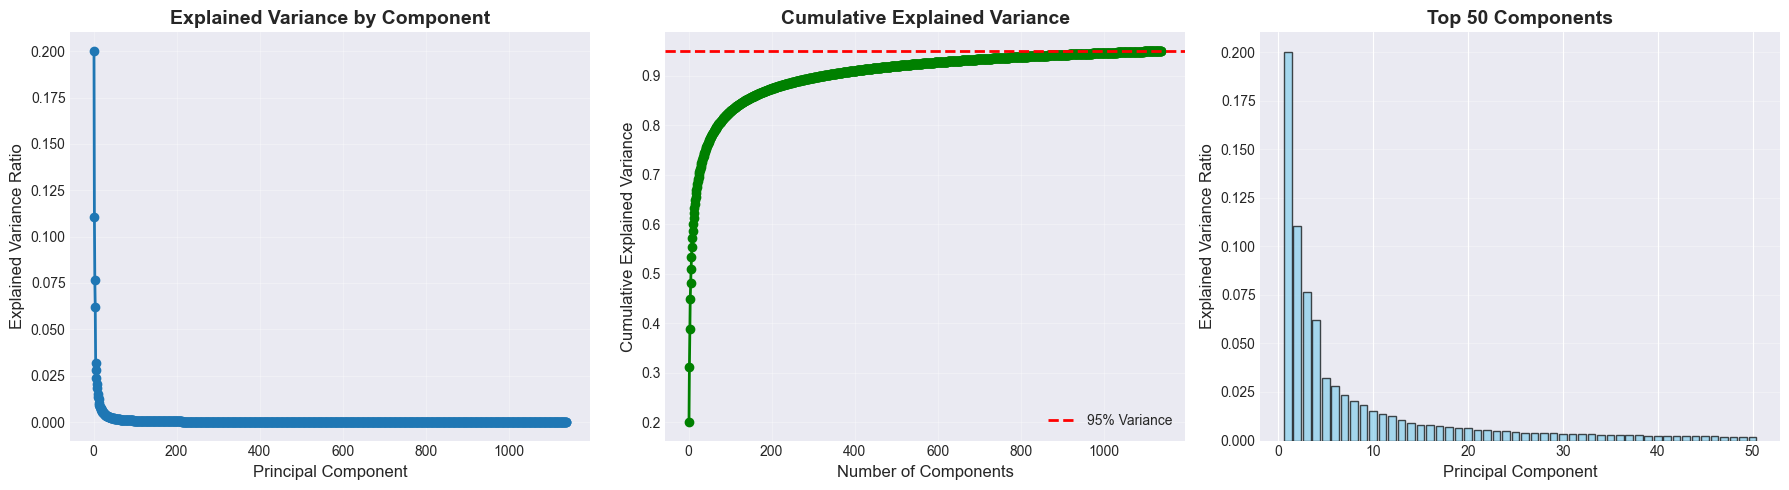


💡 PCA Visualization Explanation:
  Left: Each component's contribution to total variance
  Middle: Running total of variance explained (reaches 95%)
  Right: Bar chart of top 50 components

📊 Key Insights:
  - Top 10 components explain 58.7% of variance
  - Top 50 components explain 77.0% of variance
  - Total components needed for 95%: 1138


In [14]:
# Visualize PCA explained variance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Explained variance by component
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, marker='o', linestyle='-', linewidth=2)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Explained Variance by Component', fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative explained variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 
             marker='o', linestyle='-', linewidth=2, color='green')
axes[1].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Plot 3: First 50 components
axes[2].bar(range(1, min(51, len(pca.explained_variance_ratio_) + 1)), 
            pca.explained_variance_ratio_[:50], alpha=0.7, color='skyblue', edgecolor='black')
axes[2].set_xlabel('Principal Component', fontsize=12)
axes[2].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[2].set_title('Top 50 Components', fontweight='bold', fontsize=14)
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 PCA Visualization Explanation:")
print("  Left: Each component's contribution to total variance")
print("  Middle: Running total of variance explained (reaches 95%)")
print("  Right: Bar chart of top 50 components")
print(f"\n📊 Key Insights:")
print(f"  - Top 10 components explain {cumsum_variance[9]*100:.1f}% of variance")
print(f"  - Top 50 components explain {cumsum_variance[49]*100:.1f}% of variance")
print(f"  - Total components needed for 95%: {len(pca.components_)}")

### Visualize Principal Components

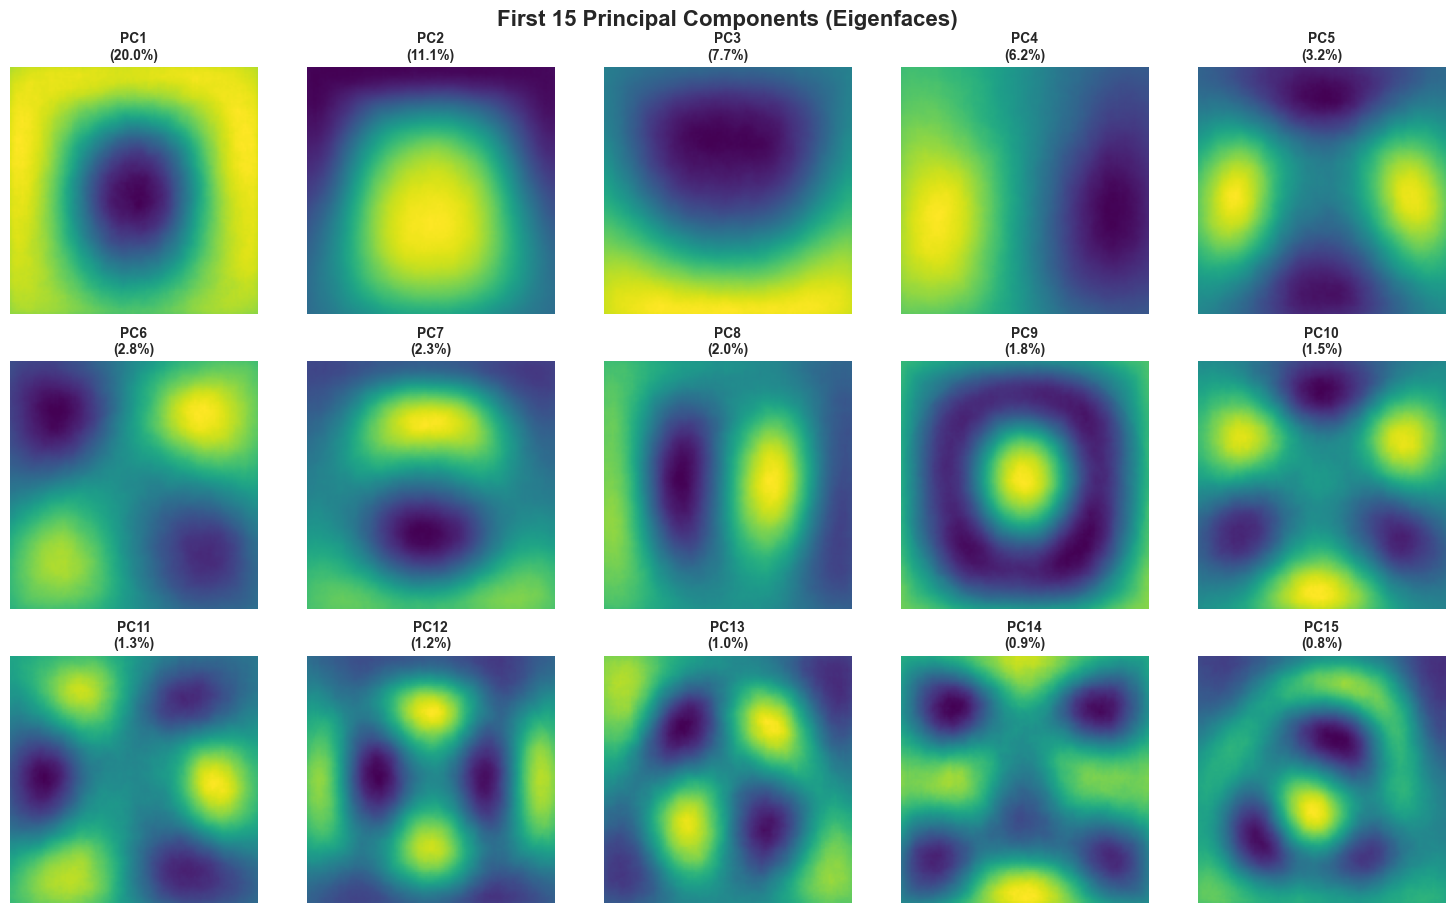


💡 These are the 'eigenfaces' - the principal patterns found in the images.
   Each component captures different aspects of image variation.


In [15]:
# Visualize first 15 principal components
n_components_to_show = min(15, len(pca.components_))
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i in range(n_components_to_show):
    # Reshape component back to image shape
    component_img = pca.components_[i].reshape(IMG_SIZE, IMG_SIZE)
    
    axes[i].imshow(component_img, cmap='viridis')
    axes[i].set_title(f'PC{i+1}\n({pca.explained_variance_ratio_[i]*100:.1f}%)', 
                     fontweight='bold', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('First 15 Principal Components (Eigenfaces)', fontsize=16, fontweight='bold', y=1.01)
plt.show()

print("\n💡 These are the 'eigenfaces' - the principal patterns found in the images.")
print("   Each component captures different aspects of image variation.")

## 🤖 SVM Model Training - Part 1: HOG Features

### Model Training Strategy

We'll train **3 different SVM models** with HOG features:
1. **Linear SVM**: Fast, works well for linearly separable data
2. **RBF SVM**: Most popular, handles non-linear patterns
3. **Polynomial SVM**: Good for polynomial relationships

---

### Model 1A: Linear SVM with HOG

In [ ]:
print("🤖 Training Linear SVM with HOG features...")
print("="*50)
start_time = time.time()

svm_linear_hog = SVC(kernel='linear', random_state=42, probability=True, verbose=True)
svm_linear_hog.fit(X_train_hog_scaled, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_linear_hog.score(X_train_hog_scaled, y_train)
test_acc = svm_linear_hog.score(X_test_hog_scaled, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

🤖 Training Linear SVM with HOG features...
[LibSVM]...................................................................................................................................

### Model 1B: RBF SVM with HOG

In [ ]:
print("\n🤖 Training RBF SVM with HOG features...")
print("="*50)
start_time = time.time()

svm_rbf_hog = SVC(kernel='rbf', random_state=42, probability=True, verbose=True)
svm_rbf_hog.fit(X_train_hog_scaled, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_rbf_hog.score(X_train_hog_scaled, y_train)
test_acc = svm_rbf_hog.score(X_test_hog_scaled, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

### Model 1C: Polynomial SVM with HOG

In [ ]:
print("\n🤖 Training Polynomial SVM with HOG features...")
print("="*50)
start_time = time.time()

svm_poly_hog = SVC(kernel='poly', degree=3, random_state=42, probability=True, verbose=True)
svm_poly_hog.fit(X_train_hog_scaled, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_poly_hog.score(X_train_hog_scaled, y_train)
test_acc = svm_poly_hog.score(X_test_hog_scaled, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

## 🤖 SVM Model Training - Part 2: PCA Features

Now we'll train the same 3 SVM variants using PCA-reduced features.

---

### Model 2A: Linear SVM with PCA

In [ ]:
print("🤖 Training Linear SVM with PCA features...")
print("="*50)
start_time = time.time()

svm_linear_pca = SVC(kernel='linear', random_state=42, probability=True, verbose=True)
svm_linear_pca.fit(X_train_pca, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_linear_pca.score(X_train_pca, y_train)
test_acc = svm_linear_pca.score(X_test_pca, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

### Model 2B: RBF SVM with PCA

In [ ]:
print("\n🤖 Training RBF SVM with PCA features...")
print("="*50)
start_time = time.time()

svm_rbf_pca = SVC(kernel='rbf', random_state=42, probability=True, verbose=True)
svm_rbf_pca.fit(X_train_pca, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_rbf_pca.score(X_train_pca, y_train)
test_acc = svm_rbf_pca.score(X_test_pca, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

### Model 2C: Polynomial SVM with PCA

In [ ]:
print("\n🤖 Training Polynomial SVM with PCA features...")
print("="*50)
start_time = time.time()

svm_poly_pca = SVC(kernel='poly', degree=3, random_state=42, probability=True, verbose=True)
svm_poly_pca.fit(X_train_pca, y_train)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Quick accuracy check
train_acc = svm_poly_pca.score(X_train_pca, y_train)
test_acc = svm_poly_pca.score(X_test_pca, y_test)
print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

## 📊 Comprehensive Model Evaluation

### Evaluation Metrics for Binary Classification:

1. **Accuracy**: Overall correctness
2. **Precision**: Of predicted positive, how many are actually positive
3. **Recall (Sensitivity)**: Of actual positive, how many we predicted
4. **F1-Score**: Harmonic mean of precision and recall
5. **ROC-AUC**: Area under ROC curve (probability-based)
6. **Balanced Accuracy**: Average of recall for each class
7. **Matthews Correlation Coefficient (MCC)**: Correlation between predictions and truth
8. **Cohen's Kappa**: Agreement between predictions and truth

---

In [ ]:
def evaluate_model_comprehensive(model, X_test, y_test, model_name):
    """
    Comprehensive evaluation of a classification model.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test : numpy.ndarray
        Test features
    y_test : numpy.ndarray
        Test labels
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict
        Dictionary of all metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate all metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'Cohen Kappa': cohen_kappa_score(y_test, y_pred)
    }
    
    return metrics, y_pred, y_pred_proba

# Evaluate all models
print("\n📊 COMPREHENSIVE MODEL EVALUATION")
print("="*70)
print("\nEvaluating all 6 models...\n")

# Evaluate HOG models
metrics_linear_hog, y_pred_linear_hog, y_pred_proba_linear_hog = evaluate_model_comprehensive(
    svm_linear_hog, X_test_hog_scaled, y_test, 'Linear SVM + HOG'
)
print("✅ Linear SVM + HOG evaluated")

metrics_rbf_hog, y_pred_rbf_hog, y_pred_proba_rbf_hog = evaluate_model_comprehensive(
    svm_rbf_hog, X_test_hog_scaled, y_test, 'RBF SVM + HOG'
)
print("✅ RBF SVM + HOG evaluated")

metrics_poly_hog, y_pred_poly_hog, y_pred_proba_poly_hog = evaluate_model_comprehensive(
    svm_poly_hog, X_test_hog_scaled, y_test, 'Polynomial SVM + HOG'
)
print("✅ Polynomial SVM + HOG evaluated")

# Evaluate PCA models
metrics_linear_pca, y_pred_linear_pca, y_pred_proba_linear_pca = evaluate_model_comprehensive(
    svm_linear_pca, X_test_pca, y_test, 'Linear SVM + PCA'
)
print("✅ Linear SVM + PCA evaluated")

metrics_rbf_pca, y_pred_rbf_pca, y_pred_proba_rbf_pca = evaluate_model_comprehensive(
    svm_rbf_pca, X_test_pca, y_test, 'RBF SVM + PCA'
)
print("✅ RBF SVM + PCA evaluated")

metrics_poly_pca, y_pred_poly_pca, y_pred_proba_poly_pca = evaluate_model_comprehensive(
    svm_poly_pca, X_test_pca, y_test, 'Polynomial SVM + PCA'
)
print("✅ Polynomial SVM + PCA evaluated")

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    metrics_linear_hog,
    metrics_rbf_hog,
    metrics_poly_hog,
    metrics_linear_pca,
    metrics_rbf_pca,
    metrics_poly_pca
])

print("\n" + "="*100)
print("📊 ALL MODELS PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Find best model
best_idx = comparison_df['Accuracy'].idxmax()
print(f"\n🏆 Best Model: {comparison_df.iloc[best_idx]['Model']}")
print(f"   Accuracy: {comparison_df.iloc[best_idx]['Accuracy']:.4f} ({comparison_df.iloc[best_idx]['Accuracy']*100:.2f}%)")
print(f"   F1-Score: {comparison_df.iloc[best_idx]['F1-Score']:.4f}")
print(f"   ROC-AUC: {comparison_df.iloc[best_idx]['ROC-AUC']:.4f}")

### Visual Comparison of All Models

In [ ]:
# Visual comparison of all metrics
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'MCC', 'Cohen Kappa']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Separate HOG and PCA models
    hog_values = comparison_df[comparison_df['Model'].str.contains('HOG')][metric].values
    pca_values = comparison_df[comparison_df['Model'].str.contains('PCA')][metric].values
    
    x = np.arange(3)
    width = 0.35
    
    ax.bar(x - width/2, hog_values, width, label='HOG', color='skyblue', edgecolor='black')
    ax.bar(x + width/2, pca_values, width, label='PCA', color='lightcoral', edgecolor='black')
    
    ax.set_xlabel('SVM Kernel', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(['Linear', 'RBF', 'Poly'], fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for j, (h_val, p_val) in enumerate(zip(hog_values, pca_values)):
        ax.text(j - width/2, h_val + 0.01, f'{h_val:.3f}', ha='center', va='bottom', fontsize=8)
        ax.text(j + width/2, p_val + 0.01, f'{p_val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('Comprehensive Metrics Comparison: HOG vs PCA', fontsize=16, fontweight='bold', y=1.01)
plt.show()

### Confusion Matrices for All Models

In [ ]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models_data = [
    ('Linear SVM + HOG', y_pred_linear_hog),
    ('RBF SVM + HOG', y_pred_rbf_hog),
    ('Polynomial SVM + HOG', y_pred_poly_hog),
    ('Linear SVM + PCA', y_pred_linear_pca),
    ('RBF SVM + PCA', y_pred_rbf_pca),
    ('Polynomial SVM + PCA', y_pred_poly_pca)
]

for idx, (name, y_pred) in enumerate(models_data):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Choose colormap based on feature extraction method
    cmap = 'Blues' if 'HOG' in name else 'Greens'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True,
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=ax)
    ax.set_title(name, fontweight='bold', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)
    
    # Add accuracy to title
    acc = accuracy_score(y_test, y_pred)
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown for best model
best_model_name = comparison_df.iloc[best_idx]['Model']
if 'HOG' in best_model_name:
    if 'Linear' in best_model_name:
        best_y_pred = y_pred_linear_hog
    elif 'RBF' in best_model_name:
        best_y_pred = y_pred_rbf_hog
    else:
        best_y_pred = y_pred_poly_hog
else:
    if 'Linear' in best_model_name:
        best_y_pred = y_pred_linear_pca
    elif 'RBF' in best_model_name:
        best_y_pred = y_pred_rbf_pca
    else:
        best_y_pred = y_pred_poly_pca

cm_best = confusion_matrix(y_test, best_y_pred)
TN, FP, FN, TP = cm_best.ravel()

print(f"\n📊 Best Model ({best_model_name}) - Confusion Matrix Breakdown:")
print("="*70)
print(f"True Negatives (TN): {TN} - Correctly predicted Cat")
print(f"False Positives (FP): {FP} - Incorrectly predicted Dog (was Cat)")
print(f"False Negatives (FN): {FN} - Incorrectly predicted Cat (was Dog)")
print(f"True Positives (TP): {TP} - Correctly predicted Dog")
print(f"\nTotal Correct: {TN + TP} / {len(y_test)} ({(TN + TP)/len(y_test)*100:.2f}%)")
print(f"Total Incorrect: {FP + FN} / {len(y_test)} ({(FP + FN)/len(y_test)*100:.2f}%)")

### ROC Curves for All Models

In [ ]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# HOG models
ax = axes[0]
models_hog = [
    ('Linear SVM + HOG', y_pred_proba_linear_hog),
    ('RBF SVM + HOG', y_pred_proba_rbf_hog),
    ('Polynomial SVM + HOG', y_pred_proba_poly_hog)
]

for name, y_pred_proba in models_hog:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - HOG Features', fontweight='bold', fontsize=14)
ax.legend(fontsize=10, loc='lower right')
ax.grid(alpha=0.3)

# PCA models
ax = axes[1]
models_pca = [
    ('Linear SVM + PCA', y_pred_proba_linear_pca),
    ('RBF SVM + PCA', y_pred_proba_rbf_pca),
    ('Polynomial SVM + PCA', y_pred_proba_poly_pca)
]

for name, y_pred_proba in models_pca:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - PCA Features', fontweight='bold', fontsize=14)
ax.legend(fontsize=10, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Classification Reports

In [ ]:
# Print detailed classification reports for all models
print("\n📋 DETAILED CLASSIFICATION REPORTS")
print("="*70)

for name, y_pred in models_data:
    print(f"\n{name}:")
    print("-" * 70)
    print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

## 🔄 HOG vs PCA Feature Extraction Comparison

### Comprehensive Comparison Analysis

In [ ]:
# Compare HOG vs PCA across kernels
print("\n📊 FEATURE EXTRACTION METHOD COMPARISON")
print("="*70)

# Average metrics for HOG
hog_metrics = comparison_df[comparison_df['Model'].str.contains('HOG')]
hog_avg = hog_metrics[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()

# Average metrics for PCA
pca_metrics = comparison_df[comparison_df['Model'].str.contains('PCA')]
pca_avg = pca_metrics[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()

print("\nAverage Performance Across All Kernels:")
print("-" * 70)
print("\nHOG Features:")
for metric, value in hog_avg.items():
    print(f"  {metric}: {value:.4f}")

print("\nPCA Features:")
for metric, value in pca_avg.items():
    print(f"  {metric}: {value:.4f}")

print("\n" + "="*70)
print("\n🏆 Winner by Average Performance:")
if hog_avg['Accuracy'] > pca_avg['Accuracy']:
    print(f"  HOG Features (Accuracy: {hog_avg['Accuracy']:.4f} vs {pca_avg['Accuracy']:.4f})")
    print(f"  Advantage: {(hog_avg['Accuracy'] - pca_avg['Accuracy'])*100:.2f}% higher accuracy")
else:
    print(f"  PCA Features (Accuracy: {pca_avg['Accuracy']:.4f} vs {hog_avg['Accuracy']:.4f})")
    print(f"  Advantage: {(pca_avg['Accuracy'] - hog_avg['Accuracy'])*100:.2f}% higher accuracy")

In [ ]:
# Visual comparison of HOG vs PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
hog_values = [hog_avg[m] for m in metrics_list]
pca_values = [pca_avg[m] for m in metrics_list]

x = np.arange(len(metrics_list))
width = 0.35

axes[0].bar(x - width/2, hog_values, width, label='HOG', color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, pca_values, width, label='PCA', color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Metric', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Average Performance: HOG vs PCA', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_list, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Add value labels
for i, (h_val, p_val) in enumerate(zip(hog_values, pca_values)):
    axes[0].text(i - width/2, h_val + 0.02, f'{h_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, p_val + 0.02, f'{p_val:.3f}', ha='center', va='bottom', fontsize=9)

# Radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics_list), endpoint=False).tolist()
hog_values_radar = hog_values + [hog_values[0]]
pca_values_radar = pca_values + [pca_values[0]]
angles += angles[:1]

ax = plt.subplot(122, projection='polar')
ax.plot(angles, hog_values_radar, 'o-', linewidth=2, label='HOG', color='skyblue')
ax.fill(angles, hog_values_radar, alpha=0.25, color='skyblue')
ax.plot(angles, pca_values_radar, 'o-', linewidth=2, label='PCA', color='lightcoral')
ax.fill(angles, pca_values_radar, alpha=0.25, color='lightcoral')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_list, fontsize=10)
ax.set_ylim(0, 1)
ax.set_title('Performance Radar Chart', fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

### Sample Predictions Visualization

In [ ]:
# Visualize sample predictions from best model
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

# Select random samples
sample_indices = np.random.choice(len(X_test_imgs), 18, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    row = idx // 6
    col = idx % 6
    ax = axes[row, col]
    
    # Get prediction from best model
    actual = y_test[sample_idx]
    predicted = best_y_pred[sample_idx]
    
    # Display image
    ax.imshow(X_test_imgs[sample_idx], cmap='gray')
    
    # Set title with actual and predicted
    actual_label = 'Dog' if actual == 1 else 'Cat'
    pred_label = 'Dog' if predicted == 1 else 'Cat'
    
    if actual == predicted:
        color = 'green'
        symbol = '✓'
    else:
        color = 'red'
        symbol = '✗'
    
    ax.set_title(f'{symbol} True: {actual_label}\nPred: {pred_label}', 
                fontsize=9, fontweight='bold', color=color)
    ax.axis('off')

plt.tight_layout()
plt.suptitle(f'Sample Predictions from Best Model ({best_model_name})', 
             fontsize=16, fontweight='bold', y=1.01)
plt.show()

# Print statistics
correct = np.sum(best_y_pred == y_test)
print(f"\n📊 Prediction Statistics:")
print(f"Correct predictions: {correct}/{len(y_test)} ({correct/len(y_test)*100:.2f}%)")
print(f"Incorrect predictions: {len(y_test)-correct}/{len(y_test)} ({(len(y_test)-correct)/len(y_test)*100:.2f}%)")

## 📝 Summary and Key Takeaways

### 🎯 Project Summary:

We successfully built and compared **6 different SVM models** for Dog vs Cat image classification:
- **3 models with HOG features**: Linear, RBF, Polynomial
- **3 models with PCA features**: Linear, RBF, Polynomial

---

### 💡 Key Learnings:

#### 1. **Feature Extraction is Critical for Image Classification**
   - Raw pixel values (16,384 features) are too high-dimensional
   - Feature extraction reduces dimensions while preserving information
   - HOG captures edge patterns and shapes
   - PCA captures principal variations in pixel intensities

#### 2. **HOG vs PCA Comparison**

**HOG Advantages:**
- ✅ Designed specifically for object detection
- ✅ Captures edge orientation and magnitude
- ✅ Robust to lighting variations
- ✅ Preserves spatial structure
- ✅ Domain-specific features

**PCA Advantages:**
- ✅ General-purpose dimensionality reduction
- ✅ Preserves maximum variance
- ✅ Removes correlated features
- ✅ Faster computation
- ✅ Fewer features than HOG

#### 3. **SVM Kernel Selection**
   - **Linear**: Fast, good baseline, works when data is linearly separable
   - **RBF**: Most popular, handles non-linear patterns, good default choice
   - **Polynomial**: Captures polynomial relationships, can overfit

#### 4. **Evaluation Metrics Matter**
   - Accuracy alone is not enough for imbalanced data
   - Precision, Recall, F1-Score provide deeper insights
   - ROC-AUC evaluates probability predictions
   - Confusion matrix shows specific error types

#### 5. **Computational Considerations**
   - Feature extraction takes significant time
   - SVM training time increases with dataset size
   - PCA reduces training time by reducing dimensions
   - Trade-off between accuracy and speed

---

### 🚀 Next Steps:

1. **Hyperparameter Tuning**
   - Use GridSearchCV to optimize C, gamma, kernel parameters
   - Cross-validation for robust evaluation

2. **Try Other Feature Extractors**
   - SIFT (Scale-Invariant Feature Transform)
   - ORB (Oriented FAST and Rotated BRIEF)
   - CNN features from pre-trained models

3. **Ensemble Methods**
   - Combine HOG and PCA features
   - Ensemble multiple SVM models
   - Voting classifier

4. **Deep Learning Comparison**
   - Compare with CNN (Convolutional Neural Networks)
   - Transfer learning with ResNet, VGG, etc.

5. **Model Deployment**
   - Save best model with pickle/joblib
   - Create web app with Streamlit/Flask
   - Deploy to cloud (AWS, GCP, Azure)

---

### 🎓 Theoretical Insights:

#### **Why SVM Works Well for Image Classification:**
1. **Maximum Margin**: Finds optimal decision boundary
2. **Kernel Trick**: Handles non-linear patterns without explicit transformation
3. **Robust to Outliers**: Only support vectors matter
4. **Works with High Dimensions**: Effective even with many features

#### **Feature Extraction Philosophy:**
- **HOG**: Hand-crafted features based on domain knowledge (computer vision)
- **PCA**: Data-driven features based on statistical variance
- Both reduce dimensionality while preserving discriminative information

---

### 📚 Additional Resources:

- **SVM Tutorial**: [Scikit-Learn SVM Guide](https://scikit-learn.org/stable/modules/svm.html)
- **HOG Explained**: [HOG Descriptor Tutorial](https://www.learnopencv.com/histogram-of-oriented-gradients/)
- **PCA Tutorial**: [Principal Component Analysis Explained](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
- **Image Classification**: [Complete Guide](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)

---

**✅ Project Complete! You've successfully implemented comprehensive SVM-based image classification with two different feature extraction techniques!**

**🐶🐱 Happy Classifying! 🚀**